# Введение в координатный спуск (coordinate descent): теория и приложения

## Постановка задачи и основное предположение

$$
\min_{x \in \mathbb{R}^n} f(x)
$$ 

- $f$ выпуклая функция
- Если по каждой координате будет выполнено $f(x + \varepsilon e_i) \geq f(x)$, будет ли это означать, что $x$ точка минимума?

- Если $f$ гладкая, то да, по критерию первого порядка $f'(x) = 0$
- Если $f$ негладкая, то нет, так как условие может быть выполнено в "угловых" точках, которые не являются точками минимума
- Если $f$ негладкая, но композитная с сепарабельной негладкой частью, то есть 
$$
f(x) = g(x) + \sum_{i=1}^n h_i(x_i),
$$
то да. Почему?

- Для любого $y$ и $x$, в котором выполнено условие оптимальности по каждому направлению, выполнено
$$
f(y) - f(x) = g(y) - g(x) + \sum_{i=1}^n (h_i(y_i) - h_i(x_i)) \geq \langle g'(x), y - x \rangle+ \sum_{i=1}^n (h_i(y_i) - h_i(x_i)) = \sum_{i=1}^n [g'_i(x)(y_i - x_i) + h_i(y_i) - h_i(x_i)] \geq 0
$$
- Значит для функций такого вида поиск минимума можно проводить покоординатно, а в результате всё равно получить точку минимума

### Вычислительные нюансы

- На этапе вычисления $i+1$ координаты используются обновлённые значения $1, 2, \ldots, i$ координат при последовательном переборе координат
- Вспомните разницу между методами Якоби и Гаусса-Зейделя для решения линейных систем!
- Порядок выбора координат имеет значение
- Сложность обновления полного вектора $\sim$ сложности обновления $n$ его компонент, то есть для покоординатного обновления целевой переменной не требуется оперировать с полным градиентом!

## Простой пример

- $f(x) = \frac12 \|Ax - b\|_2^2$, где $A \in \mathbb{R}^{m \times n}$ и $m \gg n$
- Выберем некоторую координату $i$
- Тогда покоординатное условие оптимальности $[f'(x)]_i = A^{\top}_i(Ax - b) = A^{\top}_i(A_{-i} x_{-i} + A_ix_i - b) = 0$
- Откуда $x_i = \dfrac{A^{\top}_i (b - A_{-i} x_{-i})}{\|A_i\|_2^2}$ - сложность $O(nm)$, что сопоставимо с вычислением полного градиента. Можно ли быстрее?

- Да, можно! Для этого необходимо заметить следующее

$$
x_i = \dfrac{A^{\top}_i (b - A_{-i} x_{-i})}{\|A_i\|_2^2} = \dfrac{A^{\top}_i (b - Ax + A_{i}x_i)}{\|A_i\|_2^2} = x_i - \dfrac{A^{\top}_i r}{\|A_i\|_2^2},
$$

где $r = Ax - b$

- Обновление $r$ - $\mathcal{O}(m)$, вычисление $A^{\top}_i r$ - $\mathcal{O}(m)$
- В итоге, обновить одну координату стоит $\mathcal{O}(n)$, то есть сложность обновления всех координат сопоставима с вычислением полного градиента $\mathcal{O}(mn)$

## Как выбирать координаты?

- По циклы от 1 до $n$
- Случайной перестановкой
- Правило Gauss-Southwell: $i = \arg\max_k |f'_k(x)|$ - потенциально более дорогое чем остальные

In [169]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc("text", usetex=True)
m = 1000
n = 200
A = np.random.randn(m, n)
print(np.linalg.cond(A.T @ A))
x_true = np.random.randn(n)
b = A @ x_true + 1e-3 * np.random.randn(m)

6.497288488058076


In [174]:
def coordinate_descent_lsq(x0, num_iter, sampler="sequential"):
    conv = [x0]
    x = x0.copy()
    r = A @ x0 - b
    grad = A.T @ r
    if sampler == "sequential" or sampler == "GS":
        perm = np.arange(x.shape[0])
    elif sampler == "random":
        perm = np.random.permutation(x.shape[0])
    else:
        raise ValueError("Unknown sampler!")
    
    for i in range(num_iter):
        for idx in perm:
            if sampler == "GS":
                idx = np.argmax(np.abs(grad))
            new_x_idx = x[idx] - A[:, idx] @ r / (A[:, idx] @ A[:, idx])
            r = r + A[:, idx] * (new_x_idx - x[idx])
            if sampler == "GS":
                grad = A.T @ r
            x[idx] = new_x_idx
        if sampler == "random":
            perm = np.random.permutation(x.shape[0])
        conv.append(x.copy())
#         print(np.linalg.norm(A @ x - b))
    return x, conv

In [175]:
x0 = np.random.randn(n)
num_iter = 100
x_cd_seq, conv_cd_seq = coordinate_descent_lsq(x0, num_iter)
x_cd_rand, conv_cd_rand = coordinate_descent_lsq(x0, num_iter, "random")
x_cd_gs, conv_cd_gs = coordinate_descent_lsq(x0, num_iter, "GS")

In [176]:
# !pip install git+https://github.com/amkatrutsa/liboptpy
import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss

def f(x):
    res = A @ x - b
    return 0.5 * res @ res

def gradf(x):
    res = A @ x - b
    return A.T @ res

L = np.max(np.linalg.eigvalsh(A.T @ A))

gd = methods.fo.GradientDescent(f, gradf, ss.ConstantStepSize(1 / L))
x_gd = gd.solve(x0=x0, max_iter=num_iter)

acc_gd = methods.fo.AcceleratedGD(f, gradf, ss.ConstantStepSize(1 / L))
x_accgd = acc_gd.solve(x0=x0, max_iter=num_iter)

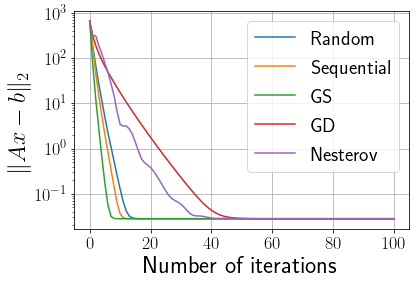

In [179]:
plt.semilogy([np.linalg.norm(A @ x - b) for x in conv_cd_rand], label="Random")
plt.semilogy([np.linalg.norm(A @ x - b) for x in conv_cd_seq], label="Sequential")
plt.semilogy([np.linalg.norm(A @ x - b) for x in conv_cd_gs], label="GS")
plt.semilogy([np.linalg.norm(A @ x - b) for x in gd.get_convergence()], label="GD")
plt.semilogy([np.linalg.norm(A @ x - b) for x in acc_gd.get_convergence()], label="Nesterov")

plt.legend(fontsize=20)
plt.xlabel("Number of iterations", fontsize=24)
plt.ylabel("$\|Ax - b\|_2$", fontsize=24)
plt.grid(True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

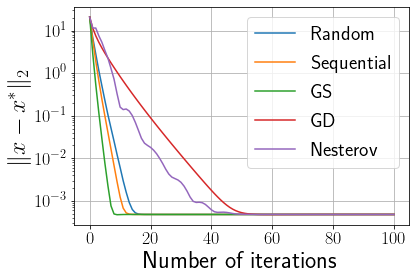

In [181]:
plt.semilogy([np.linalg.norm(x - x_true) for x in conv_cd_rand], label="Random")
plt.semilogy([np.linalg.norm(x - x_true) for x in conv_cd_seq], label="Sequential")
plt.semilogy([np.linalg.norm(x - x_true) for x in conv_cd_gs], label="GS")
plt.semilogy([np.linalg.norm(x - x_true) for x in gd.get_convergence()], label="GD")
plt.semilogy([np.linalg.norm(x - x_true) for x in acc_gd.get_convergence()], label="Nesterov")
plt.legend(fontsize=20)
plt.xlabel("Number of iterations", fontsize=24)
plt.ylabel("$\|x - x^*\|_2$", fontsize=24)
plt.grid(True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

## Сходимость

- Сублинейная для выпуклых глакдих с Липшицевым градиентом
- Линейная для сильно выпуклых функций
- Прямая аналогия с градиентным спуском
- Но много особенностей использования

## Типичные примеры использования

- Lasso (снова)
- SMO метод обучения SVM - блочный координатный спуск с размером блока равным 2
- Вывод в графических моделях